# Noise2Self for Neural Nets

This is a simple notebook demonstrating the principle of using self-supervision to train denoising networks.

For didactic purposes, we use a simple dataset (Gaussian noise on MNIST), a simple model (a small UNet), and a short training (100 iterations on a CPU). This notebook runs on a MacBook Pro in under one minute.

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys
sys.path.append("..")

In [3]:
from util import show, plot_images, plot_tensors

# Data

We demonstrate the use of a self-supervised denoising objective on a synthetically noised version of MNIST.

In [ ]:
from torchvision.datasets import MNIST
from torchvision import transforms
from torch.utils.data import Dataset

mnist_train = MNIST('../data/MNIST', download = True,
                    transform = transforms.Compose([
                        transforms.ToTensor(),
                    ]), train = True)

mnist_test = MNIST('../data/MNIST', download = True,
                    transform = transforms.Compose([
                        transforms.ToTensor(),
                    ]), train = False)

In [4]:
#Unet
from torchvision.datasets import MNIST
from torchvision import transforms
from torch.utils.data import Dataset

mnist_train = MNIST('../data/MNIST', download = True,
                    transform = transforms.Compose([
                        transforms.Resize([32,32]),#Unet
                        transforms.ToTensor(),
                    ]), train = True)

mnist_test = MNIST('../data/MNIST', download = True,
                    transform = transforms.Compose([
                        transforms.Resize([32,32]),#Unet
                        transforms.ToTensor(),
                    ]), train = False)

In [5]:
from torch import randn
def add_noise(img):
    return img + randn(img.size())*0.4

class SyntheticNoiseDataset(Dataset):
    def __init__(self, data, mode='train'):
        self.mode = mode
        self.data = data
        
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, index):
        img = self.data[index][0]
        return add_noise(img), img

In [ ]:
import numpy as np

print(mnist_train)
print(mnist_train[0])
print(mnist_train[0][1])


In [6]:
noisy_mnist_train = SyntheticNoiseDataset(mnist_train, 'train')
noisy_mnist_test = SyntheticNoiseDataset(mnist_test, 'test')

In [ ]:
import numpy as np

print(len(noisy_mnist_train))
print("num0:")
print(noisy_mnist_train[0])
print("num0dimention0:")
print(noisy_mnist_train[0][0])


We will try to learn to predict the clean image on the right from the noisy image on the left.

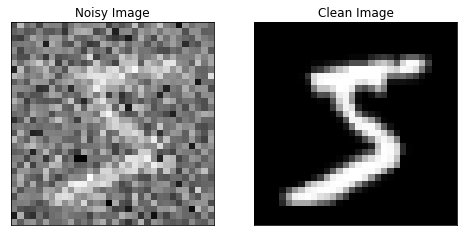

In [7]:
noisy, clean = noisy_mnist_train[0]
plot_tensors([noisy[0], clean[0]], ['Noisy Image', 'Clean Image'])

In [ ]:
print(noisy.shape)

# Masking

The strategy is to train a $J$-invariant version of a neural net by replacing a grid of pixels with the average of their neighbors, then only evaluating the model on the masked pixels.

In [8]:
from mask import Masker
masker = Masker(width = 4, mode='interpolate')

In [ ]:
print(len(masker))

In [9]:
net_input, mask = masker.mask(noisy.unsqueeze(0), 0)

In [ ]:
print(mask)

In [ ]:
print(noisy.unsqueeze(0).shape)
print(noisy.unsqueeze(0)[0,0].shape)
print(noisy.unsqueeze(0)[0,0].shape[-2])
print(noisy.unsqueeze(0)[0,0].shape[-1])
print(noisy.unsqueeze(0)[0,0].shape[0])
print(noisy.unsqueeze(0)[0,0].shape[1])


A mask; the data; the input to the neural net, which doesn't depend on the values of $x$ inside the mask; and the difference between the neural net input and $x$.

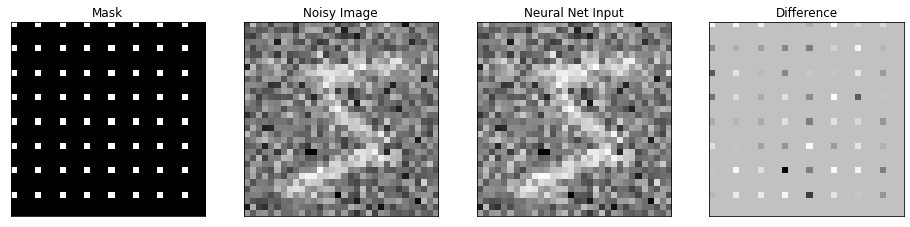

In [10]:
plot_tensors([mask, noisy[0], net_input[0], net_input[0] - noisy[0]],
            ["Mask", "Noisy Image", "Neural Net Input", "Difference"])

# Model

For our model, we use a short UNet with two levels of up- and down- sampling

In [11]:
from models.babyunet import BabyUnet
from models.unet import Unet
from models.dncnn import DnCNN

model = DnCNN(1)

# Training

In [12]:
from torch.nn import MSELoss
from torch.optim import Adam
from torch.utils.data import DataLoader

loss_function = MSELoss()
optimizer = Adam(model.parameters(), lr=0.001)

In [ ]:
#self-supervised
data_loader = DataLoader(noisy_mnist_train, batch_size=32, shuffle=True)

for epoch in range(1):
    for i, batch in enumerate(data_loader): 
        noisy_images, clean_images = batch

        net_input, mask = masker.mask(noisy_images, i)
        net_output = model(net_input)

        loss = loss_function(net_output*mask, noisy_images*mask)

        optimizer.zero_grad()

        loss.backward()

        optimizer.step()

        if i % 10 == 0:
            print("Loss (", i, "): \t", round(loss.item(), 4))

        #if i == 100:
        #    break
   

In [13]:
#supervised
data_loader = DataLoader(noisy_mnist_train, batch_size=32, shuffle=True)

for epoch in range(1):
    for i, batch in enumerate(data_loader):
        noisy_images, clean_images = batch
        
        output = model(noisy_images)
        
        loss = loss_function(output, clean_images)
        
        optimizer.zero_grad()
        
        loss.backward()
        
        optimizer.step()
        
        if i % 10 == 0:
            print("Loss(", i, ") : \t", round(loss.item(), 4))

Loss( 0 ) : 	 0.3487
Loss( 10 ) : 	 0.0163
Loss( 20 ) : 	 0.0083
Loss( 30 ) : 	 0.0067
Loss( 40 ) : 	 0.0065
Loss( 50 ) : 	 0.0066
Loss( 60 ) : 	 0.0071
Loss( 70 ) : 	 0.0065
Loss( 80 ) : 	 0.006
Loss( 90 ) : 	 0.0054
Loss( 100 ) : 	 0.007
Loss( 110 ) : 	 0.0058
Loss( 120 ) : 	 0.0052
Loss( 130 ) : 	 0.0056
Loss( 140 ) : 	 0.0058
Loss( 150 ) : 	 0.0051
Loss( 160 ) : 	 0.006
Loss( 170 ) : 	 0.0051
Loss( 180 ) : 	 0.0047
Loss( 190 ) : 	 0.0055
Loss( 200 ) : 	 0.0081
Loss( 210 ) : 	 0.0061
Loss( 220 ) : 	 0.0053
Loss( 230 ) : 	 0.0057
Loss( 240 ) : 	 0.0061
Loss( 250 ) : 	 0.0054
Loss( 260 ) : 	 0.006
Loss( 270 ) : 	 0.0067
Loss( 280 ) : 	 0.0056
Loss( 290 ) : 	 0.0049
Loss( 300 ) : 	 0.0053
Loss( 310 ) : 	 0.0056
Loss( 320 ) : 	 0.0058
Loss( 330 ) : 	 0.005
Loss( 340 ) : 	 0.0052
Loss( 350 ) : 	 0.0048
Loss( 360 ) : 	 0.0055
Loss( 370 ) : 	 0.0053
Loss( 380 ) : 	 0.0078
Loss( 390 ) : 	 0.0058
Loss( 400 ) : 	 0.0063
Loss( 410 ) : 	 0.005
Loss( 420 ) : 	 0.0058
Loss( 430 ) : 	 0.0061
Loss(

In [ ]:
print(data_loader)
print(i)

In [14]:
test_data_loader = DataLoader(noisy_mnist_test,
                                              batch_size=32,
                                              shuffle=False,
                                              num_workers=3)
i, test_batch = next(enumerate(test_data_loader))
noisy, clean = test_batch

With our trained model, we have a choice. We may do a full $J$-invariant reconstruction, or we may just run the noisy data through the network unaltered.

In [15]:
simple_output = model(noisy)
invariant_output = masker.infer_full_image(noisy, model)

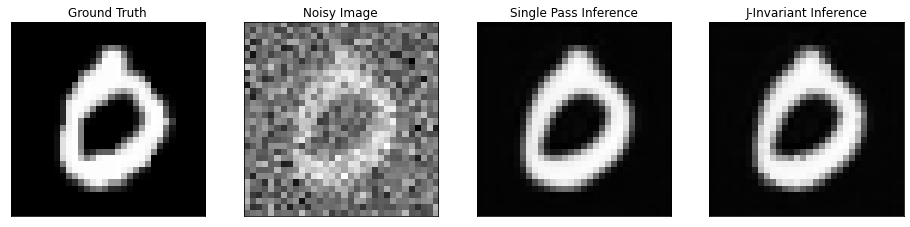

In [16]:
idx = 3
plot_tensors([clean[idx], noisy[idx], simple_output[idx], invariant_output[idx]],
            ["Ground Truth", "Noisy Image", "Single Pass Inference", "J-Invariant Inference"])

In [18]:
print("Test loss, single pass: ", round(loss_function(clean, simple_output).item(), 3))
print("Test loss, J-invariant: ", round(loss_function(clean, invariant_output).item(), 3))

Test loss, single pass:  0.005
Test loss, J-invariant:  0.005


While both the simple and invariant output are significantly denoised, the invariant output has a mild pixelation. 

This is due to the fact that neighboring pixels are denoised using different information, leading to discontinuities in the reconstructed output.

In [19]:
from util import ssim, psnr
import torch
print("Test ssim, simple pass: ", ssim(clean, simple_output).item())
print("Test ssim, J-invariant: ", ssim(clean, invariant_output).item())
print(torch.max(clean))
print("Test psnr, simple pass: ", torch.mean(psnr(clean, simple_output)))
print("Test psnr, J-invariant: ", torch.mean(psnr(clean, invariant_output)))

Test ssim, simple pass:  0.7596167325973511
Test ssim, J-invariant:  0.7525436878204346
tensor(1.)
Test psnr, simple pass:  tensor(23.7366, grad_fn=<MeanBackward0>)
Test psnr, J-invariant:  tensor(22.9369, grad_fn=<MeanBackward0>)


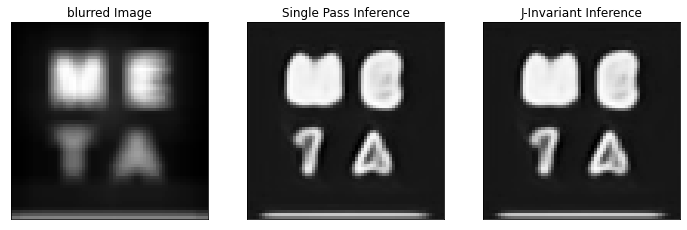

In [20]:
from PIL import Image

loader = transforms.Compose([
    transforms.Resize([64,64]),transforms.ToTensor()]) 
blurred_meta = Image.open('../figs/blurred_meta.bmp')
blurred_meta = loader(blurred_meta).unsqueeze(0)
blurred_meta.to(blurred_meta.device)

simple_out_meta = model(blurred_meta)
invariant_out_meta = masker.infer_full_image(blurred_meta, model)

plot_tensors([blurred_meta, simple_out_meta, invariant_out_meta],
            ["blurred Image", "Single Pass Inference", "J-Invariant Inference"])